## Predicting Loan Payback

##### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, auc
import pickle
import warnings
warnings.filterwarnings("ignore")

/home/petpooja/MYWORK/Loan_prediction_api/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sklearn
import xgboost

print(sklearn.__version__)
print(xgboost.__version__)


1.8.0
3.1.3


##### Reading the datasets

In [3]:
df_train = pd.read_csv("data/train.csv")
df_train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


##### EDA and some Visualizations

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254569 entries, 0 to 254568
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    254569 non-null  int64  
 1   annual_income         254569 non-null  float64
 2   debt_to_income_ratio  254569 non-null  float64
 3   credit_score          254569 non-null  int64  
 4   loan_amount           254569 non-null  float64
 5   interest_rate         254569 non-null  float64
 6   gender                254569 non-null  object 
 7   marital_status        254569 non-null  object 
 8   education_level       254569 non-null  object 
 9   employment_status     254569 non-null  object 
 10  loan_purpose          254569 non-null  object 
 11  grade_subgrade        254569 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 23.3+ MB


#### No null values and duplicates.

In [7]:
df_train["loan_paid_back"].value_counts()

loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64

1 = Loan PAID BACK (good customer) → Majority class <br>
0 = Loan NOT paid back (default / risky customer) → Minority class

Goal : Predict probability of loan being paid back<br>
So we will treat : Positive class = 1 = paid back

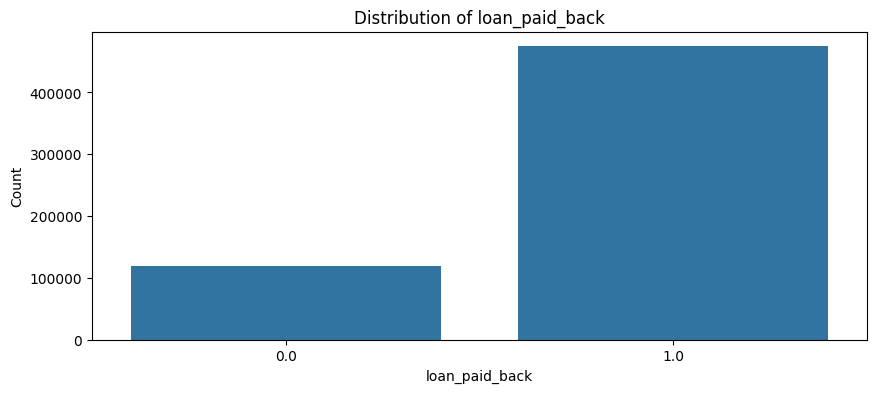

In [8]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df_train, x='loan_paid_back')
plt.title('Distribution of loan_paid_back')
plt.xlabel('loan_paid_back')
plt.ylabel('Count')
plt.show()

In [9]:
column = ["gender","marital_status","education_level","employment_status","loan_purpose","grade_subgrade"]
for i in column:
    print(i,"has",df_train[i].unique(),"unique categories.","\n")

gender has ['Female' 'Male' 'Other'] unique categories. 

marital_status has ['Single' 'Married' 'Divorced' 'Widowed'] unique categories. 

education_level has ['High School' "Master's" "Bachelor's" 'PhD' 'Other'] unique categories. 

employment_status has ['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student'] unique categories. 

loan_purpose has ['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business'] unique categories. 

grade_subgrade has ['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2'] unique categories. 



## Correct Feature/Target Split 

In [10]:
test_id =  df_test['id'].copy()
X_train = df_train.drop(["id","loan_paid_back"],axis = 1)
y_train  = df_train["loan_paid_back"]
X_test = df_test.drop('id', axis=1)

##### Handling the Categorical columns

In [11]:
# Force categorical columns to object dtype (CRITICAL for pickle stability)
cat_cols = ["gender","marital_status","education_level","employment_status","loan_purpose",
            "grade_subgrade"]
for col in cat_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)


In [12]:
# Build the sorted order for grade_subgrade
grades = sorted(X_train['grade_subgrade'].unique(),
                key=lambda x: (x[0], int(x[1]) if x[1].isdigit() else 0))
print('grade_subgrade order (', len(grades), 'values):')  
print(grades)

grade_subgrade order ( 30 values):
['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5']


In [13]:
# Separate the ordinal column from the nominal categoricals
ordinal_cols  = ['grade_subgrade']
nominal_cols  = [c for c in cat_cols if c not in ordinal_cols]
numeric_cols  = X_train.select_dtypes(include=np.number).columns.tolist()

print('\nNominal cols :', nominal_cols)
print('Ordinal cols :', ordinal_cols)
print('Numeric cols :', numeric_cols)


Nominal cols : ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']
Ordinal cols : ['grade_subgrade']
Numeric cols : ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']


## Build the Preprocessor

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=False),nominal_cols),
        ('ordinal', OrdinalEncoder(categories=[grades], handle_unknown='use_encoded_value', unknown_value=-1),ordinal_cols),
        ('num', 'passthrough', numeric_cols),
    ],
    remainder='drop'
)

In [15]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(scale_pos_weight)

0.25184723094496453


---
## Hyperparameter Tuning with Optuna

**Optuna** intelligently samples hyperparameter combinations using TPE  
(Tree-structured Parzen Estimator) and validates each on X_val.  

Unlike GridSearch which tries EVERY combination (expensive),  
Optuna learns from previous trials and focuses on promising regions of the  
hyperparameter space → finds good params faster.

In [16]:
# Suppress verbose output
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'n_estimators'    : trial.suggest_int('n_estimators', 300, 600),
        'max_depth'       : trial.suggest_int('max_depth', 3, 7),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'subsample'       : trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma'           : trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 1e-4, 5.0, log=True),
        'max_delta_step'  : 1,
        'tree_method'     : 'hist',
        'objective'       : 'binary:logistic',
        'eval_metric'     : 'auc',
        'scale_pos_weight': scale_pos_weight,
        'random_state'    : 42,
    }
    
    model = xgb.XGBClassifier(**params)
    pipeline_trial = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier',   model)
    ])
    
    # 3-fold CV on FULL X_train
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(
        pipeline_trial, X_train, y_train,
        cv=cv, scoring='roc_auc', n_jobs=-1
    )
    return scores.mean()

# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=False)

# Print clean results
print(f'\n{"="*60}')
print('HYPERPARAMETER TUNING COMPLETE')
print(f'{"="*60}')
print(f'Best 3-Fold CV AUC: {study.best_value:.6f}')
print(f'\nBest Parameters:')
for k, v in study.best_params.items():
    print(f'  {k:20s}: {v}')
print(f'{"="*60}\n')


HYPERPARAMETER TUNING COMPLETE
Best 3-Fold CV AUC: 0.920811

Best Parameters:
  n_estimators        : 438
  max_depth           : 6
  learning_rate       : 0.08353363351576297
  subsample           : 0.8889254497425585
  colsample_bytree    : 0.8738627993943915
  min_child_weight    : 1
  gamma               : 0.30755170092581474
  reg_alpha           : 0.001133988907815844
  reg_lambda          : 0.0007675986628055382



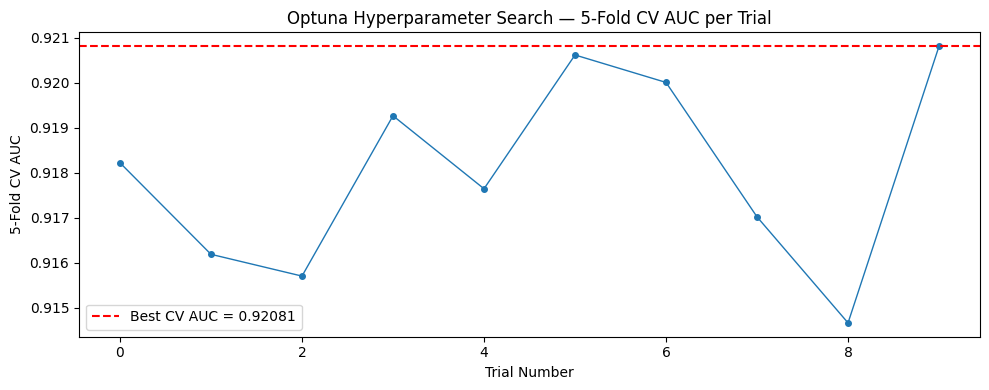

In [17]:
# Plot Optuna optimization history
trial_values = [t.value for t in study.trials]
plt.figure(figsize=(10, 4))
plt.plot(trial_values, marker='o', markersize=4, linewidth=1)
plt.axhline(y=study.best_value, color='red', linestyle='--', 
            label=f'Best CV AUC = {study.best_value:.5f}')
plt.xlabel('Trial Number')
plt.ylabel('5-Fold CV AUC')  
plt.title('Optuna Hyperparameter Search — 5-Fold CV AUC per Trial')
plt.legend()
plt.tight_layout()
plt.show()

---
## Train / Validation Split

In [18]:
# NOW split for final evaluation (after hyperparameter tuning)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)
print(f'X_tr: {X_tr.shape} | X_val: {X_val.shape}')

X_tr: (475195, 11) | X_val: (118799, 11)


---
## Train Final Pipeline with Best Params

In [19]:
best_params = study.best_params
best_params.update({
    'max_delta_step'  : 1,
    'tree_method'     : 'hist',
    'objective'       : 'binary:logistic',
    'eval_metric'     : 'auc',
    'scale_pos_weight': scale_pos_weight,
    'random_state'    : 42,
})

final_model = xgb.XGBClassifier(**best_params)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',   final_model)
])

pipeline.fit(X_tr, y_tr)
print('Pipeline fitted on X_tr:', X_tr.shape)

Pipeline fitted on X_tr: (475195, 11)


---
## Evaluation on Validation Set

In [20]:
y_val_pred = pipeline.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_val_pred))

Accuracy: 0.8675830604634719


In [21]:
y_val_prob = pipeline.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

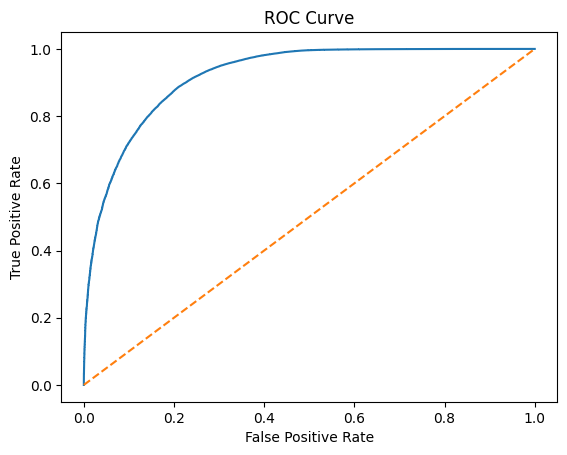

In [22]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [23]:
J = tpr - fpr
best_idx = np.argmax(J)
best_threshold = thresholds[best_idx]

print("Optimal threshold:", best_threshold)

Optimal threshold: 0.5033442974090576


In [24]:
y_val_prob = pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_prob >= best_threshold).astype(int)
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

         0.0       0.64      0.79      0.70     23900
         1.0       0.94      0.89      0.91     94899

    accuracy                           0.87    118799
   macro avg       0.79      0.84      0.81    118799
weighted avg       0.88      0.87      0.87    118799



In [25]:
y_val_prob = pipeline.predict_proba(X_val)[:, 1]
SCORE = roc_auc_score(y_val, y_val_prob)
print("ROC-AUC:", SCORE)

ROC-AUC: 0.9204415454069402


---
## Test Set Predictions

In [26]:
final = pipeline.predict_proba(X_test)[:,1]
#preds = (final >= best_threshold).astype(int)
final = pd.DataFrame({'id': test_id, 'loan_paid_back' : final})
final.head()

,id,loan_paid_back
0,593994,0.791615
1,593995,0.919737
2,593996,0.248636
3,593997,0.696857
4,593998,0.884078


---
## Save Model

In [27]:
# Save the trained pipeline using pickle
pickle_model_path = "model.pkl"
with open(pickle_model_path, "wb") as f:
    pickle.dump(pipeline, f)

In [28]:
# Save metadata alongside the model for reference
import json
metadata = {
    'best_params'      : {k: (float(v) if isinstance(v, float) else int(v) if isinstance(v, (np.integer,)) else v)
                          for k, v in best_params.items()},
    'optuna_cv_auc'    : round(float(study.best_value), 6),  # NEW: From Optuna
    'val_auc'          : round(float(SCORE), 6),             # Changed name: X_val AUC
    'optimal_threshold': round(float(best_threshold), 6),
    'nominal_cols'     : nominal_cols,
    'ordinal_cols'     : ordinal_cols,
    'numeric_cols'     : numeric_cols,
    'grade_order'      : grades,
}
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print('Metadata saved to model_metadata.json')

Metadata saved to model_metadata.json
